# Подготовка прототипа модели машинного обучения для «Цифры».

Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

## Описание данных
Технологический процесс

- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
- Xanthate **— ксантогенат (промотер, или активатор флотации);
- Sulphate — сульфат (на данном производстве сульфид натрия);
- Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота

Параметры этапов
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи

Наименование признаков:<br>
[этап].[тип_параметра].[название_параметра]<br>
Пример: rougher.input.feed_ag

Возможные значения для блока [этап]:<br>
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики<br>

Возможные значения для блока [тип_параметра]:<br>
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

# План работы

1. Подготовка данных <br/>
1.1. Изучение данных<br/>
1.2. Подготовка обучаемой и тестовой наборов данных<br/>
1.3. Признаки, недоступные в тестовой выборке<br/>
1.4. Проверка расчета эффективности обогащения
2. Анализ данных<br/>
2.1. Изменение концентрации металлов (Au, Ag, Pb) на различных этапах очистки<br/>
2.2. Сравнение распределение размеров гранул сырья на обучающей и тестовой выборках<br/>
2.3. Исследование суммарной концентрации всех веществ на разных стадиях<br/>
3. Построение модели <br/>
3.1. Функция для вычисления итоговой sMAPE<br/>
3.2. Подготовка данных для обучения<br/>
3.3. Модель линейной регрессии<br/>
3.4. Модель случайный лес<br/>
3.5. Тестирование модели<br/>
3.6. Сравнение с константной моделью
4. Выводы

# 1. Подготовка данных

## 1.1. Изучение данных

In [2]:
#импортируем библиотеки
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import os
import urllib.request
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
import warnings 
warnings.filterwarnings('ignore')

In [3]:
#загружаем данные
Path('datasets').mkdir(parents=True, exist_ok=True)

def get_file(file_name, url):
    if not os.path.exists(file_name):
        print(file_name, 'файл не найден, будет загружен из сети')
        _=urllib.request.urlretrive(url, file_name)
        
urls = {
    'gold_recovery_full': ('/datasets/gold_recovery_full.csv', 'https://code.s3.yandex.net/datasets/gold_recovery_full.csv'),
    'gold_recovery_train': ('/datasets/gold_recovery_train.csv', 'https://code.s3.yandex.net/datasets/gold_recovery_train.csv'),
    'gold_recovery_test': ('/datasets/gold_recovery_test.csv', 'https://code.s3.yandex.net/datasets/gold_recovery_test.csv'),
}

[get_file(*urls[k]) for k in urls]

df_full = pd.read_csv(urls['gold_recovery_full'][0], index_col='date', parse_dates=True)
df_train = pd.read_csv(urls['gold_recovery_train'][0], index_col='date',  parse_dates=True)
df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant                      15598 non-null float64
primary_c

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [4]:
df_test = pd.read_csv(urls['gold_recovery_test'][0], index_col='date',  parse_dates=True)

df_test.info()
df_test.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5856 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.input.feed_ag                    

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


- Всего в полном и тренировочных датасетах по 86 признаков и 16 860 объектов, в то время как в тестовой их 52 и 5 865
- В отличие от обучающей выборки, в тестовой имеются признаки с финальными характеристиками
- Все признаки, кроме даты, вещественного типа float.

## 1.2. Признаки, недоступные в тестовой выборке

In [5]:
df_train_columns = set(df_train.columns)
df_test_columns = set(df_test.columns)
missing_columns = df_train_columns - df_test_columns
len(missing_columns)
missing_columns

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

По большому счету в обучающей выборке нет 34 признаков по всем этапам со следующими параметрами продукта: концентрация и остатки.

## 1.3. Подготовка наборов данных

In [6]:
#выделили в отдельный датасет вводные для ручного вычисления эффективности обогащения
df_recovery = df_train[['rougher.output.concentrate_au', 'rougher.input.feed_au', 
                   'rougher.output.tail_au', 'final.output.recovery']].dropna().reset_index(drop=True)

df_recovery.fillna(method = 'ffill', inplace=True)
df_recovery = df_recovery[df_recovery['rougher.input.feed_au'] != 0]
df_recovery = df_recovery[df_recovery['rougher.input.feed_au'] >= df_recovery['rougher.output.tail_au']]
df_recovery = df_recovery[df_recovery['rougher.output.concentrate_au'] >= df_recovery['rougher.input.feed_au']]

df_recovery.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13845 entries, 0 to 14372
Data columns (total 4 columns):
rougher.output.concentrate_au    13845 non-null float64
rougher.input.feed_au            13845 non-null float64
rougher.output.tail_au           13845 non-null float64
final.output.recovery            13845 non-null float64
dtypes: float64(4)
memory usage: 540.8 KB


In [7]:
#включем в тестовый набор данных 2 целевых признака 
df_test = df_test.merge(df_full[['final.output.recovery', 'rougher.output.recovery']], 
                       'left', 'date')
df_test.shape #(5856, 54)

(5856, 54)

In [8]:
#оставляем в тренировочном только те признаки, которые содержатся в тестовой
df_train = df_train[df_test.columns]
df_train.shape #(16860, 54)

(16860, 54)

In [9]:
#проверка на пропуски
(df_train.isnull().sum().sort_values(ascending=False)/len(df_train)).apply(lambda x: '{:.2%}'.format(x)).head()
(df_test.isnull().sum().sort_values(ascending=False)/len(df_train)).apply(lambda x: '{:.2%}'.format(x)).head()

rougher.output.recovery               3.24%
final.output.recovery                 2.62%
rougher.input.floatbank11_xanthate    2.09%
primary_cleaner.input.sulfate         1.79%
primary_cleaner.input.depressant      1.68%
dtype: object

In [10]:
#убираем строки с пропусками в целевых признаках
df_train = df_train[~df_train['rougher.output.recovery'].isna() & ~df_train['final.output.recovery'].isna()]
df_test = df_test[~df_test['rougher.output.recovery'].isna() & ~df_test['final.output.recovery'].isna()]
df_full = df_full[~df_full['rougher.output.recovery'].isna() & ~df_full['final.output.recovery'].isna()]

In [11]:
#заполняем оставшие пропуски
df_train.fillna(method = 'ffill', inplace=True)
df_test.fillna(method = 'ffill', inplace=True)
df_full.fillna(method = 'ffill', inplace=True)

- Пропуски в целевых признаках не стали заполнить расчетными значениями, так как это может исказить их и тем самым мы неправильно обучим модель, поэтому их просто удаляем.

- Остальные же колонки заполним, чтобы у нас было больше записей для обучения. Трюк провернули с помощью умным метода ffill, потому что он заполняет пропуска соседними данными и подходит для даннных упорядоченных по времени.

## 1.4. Проверка расчета эффективности обогащения

In [12]:
df_recovery.describe()

,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au,final.output.recovery
count,13845.000000,13845.000000,13845.000000,13845.000000
mean,19.866627,7.856833,1.754967,66.544247
std,2.452372,1.910439,0.716202,10.246274
min,1.912582,0.588152,0.020676,0.000000
25%,18.565063,6.584690,1.307045,62.644053
50%,20.006954,7.634302,1.740080,67.445028
75%,21.433728,9.064500,2.185539,72.336396
max,28.146838,13.126043,9.688980,100.000000


In [13]:
#пропишем функцию
def recovery(df, c, t, f):
    '''
    Рассчитываем вручную обогащение
    C — доля золота в концентрате после флотации/очистки;
    F — доля золота в сырье/концентрате до флотации/очистки;
    T — доля золота в отвальных хвостах после флотации/очистки.
    '''
    C = df[c]
    T = df[t]
    F = df[f]
    recovery = (C * (F - T)) / (F * (C - T)) * 100
    return recovery

df_recovery['new_recovery'] = recovery(df_recovery, 
                                   c = 'rougher.output.concentrate_au', 
                                   f = 'rougher.input.feed_au', 
                                   t = 'rougher.output.tail_au')
df_recovery.head()

,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au,final.output.recovery,new_recovery
0,19.793808,6.486150,1.170244,70.541216,87.107763
1,20.050975,6.478583,1.184827,69.266198,86.843261
2,19.737170,6.362222,1.162562,68.116445,86.842308
3,19.320810,6.118189,1.079755,68.347543,87.226430
4,19.216101,5.663707,1.012642,66.927016,86.688794


In [14]:
df_recovery = df_recovery[['final.output.recovery', 'new_recovery']].dropna()
rec_mae = mean_absolute_error(df_recovery['final.output.recovery'], df_recovery['new_recovery'])
print(rec_mae)

18.246735359651314


In [15]:
df_recovery[['final.output.recovery', 'new_recovery']].describe()

,final.output.recovery,new_recovery
count,13845.000000,13845.000000
mean,66.544247,84.476873
std,10.246274,8.007446
min,0.000000,2.520854
25%,62.644053,80.352605
50%,67.445028,85.503977
75%,72.336396,90.267592
max,100.000000,99.979041


Рассчитали вручную эффективность обогащения, статистика схожа с предоставленным признаком recovery

# 2. Анализ данных

## 2.1. Изменение концентрации металлов (Au, Ag, Pb) на различных этапах очистки. 

#### 2.1.1. Золото Au

In [16]:
df_au = df_full[['rougher.input.feed_au',
                'rougher.output.concentrate_au',
                'primary_cleaner.output.concentrate_au', 
                'final.output.concentrate_au']].reset_index().drop(['date'], axis=1) 

df_au.head()

,rougher.input.feed_au,rougher.output.concentrate_au,primary_cleaner.output.concentrate_au,final.output.concentrate_au
0,6.486150,19.793808,34.174427,42.192020
1,6.478583,20.050975,34.118526,42.701629
2,6.362222,19.737170,33.969464,42.657501
3,6.118189,19.320810,28.260743,42.689819
4,5.663707,19.216101,33.044932,42.774141


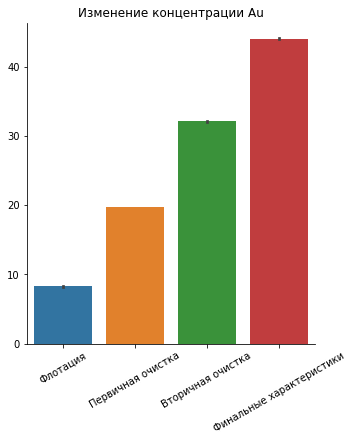

In [17]:
a = sns.catplot(data=df_au, kind = 'bar')
a.set_xticklabels(["Флотация", "Первичная очистка", "Вторичная очистка", "Финальные характеристики"],
                 rotation = 30)
plt.title('Изменение концентрации Au')
plt.show()

Содержание золота с каждым этапом увеличивается, что логично

#### 2.1.2. Серебро Ag

In [18]:
df_ag = df_full[['rougher.input.feed_ag',
                'rougher.output.concentrate_ag',
                'primary_cleaner.output.concentrate_ag', 
                'final.output.concentrate_ag']].reset_index().drop(['date'], axis=1) 

df_ag.head()

,rougher.input.feed_ag,rougher.output.concentrate_ag,primary_cleaner.output.concentrate_ag,final.output.concentrate_ag
0,6.100378,11.500771,8.547551,6.055403
1,6.161113,11.615865,8.558743,6.029369
2,6.116455,11.695753,8.603505,6.055926
3,6.043309,11.915047,7.221879,6.047977
4,6.060915,12.411054,9.089428,6.148599


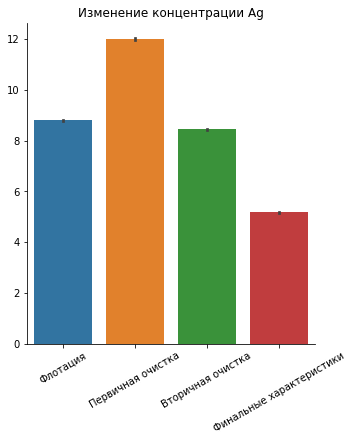

In [19]:
a = sns.catplot(data=df_ag, kind = 'bar')
a.set_xticklabels(["Флотация", "Первичная очистка", "Вторичная очистка", "Финальные характеристики"],
                 rotation = 30)
plt.title('Изменение концентрации Ag')
plt.show()

Количество серебра увеличивается на второй этапе, после обогащения чернового концентрата и далее вымывается

#### 2.1.3. Свинец Pb

In [20]:
df_pb = df_full[['rougher.input.feed_pb',
                'rougher.output.concentrate_pb',
                'primary_cleaner.output.concentrate_pb', 
                'final.output.concentrate_pb']].reset_index().drop(['date'], axis=1) 

df_pb.head()

,rougher.input.feed_pb,rougher.output.concentrate_pb,primary_cleaner.output.concentrate_pb,final.output.concentrate_pb
0,2.284912,7.101074,10.389648,9.889648
1,2.266033,7.278807,10.497069,9.968944
2,2.159622,7.216833,10.354494,10.213995
3,2.037807,7.175616,8.496563,9.977019
4,1.786875,7.240205,9.986786,10.142511


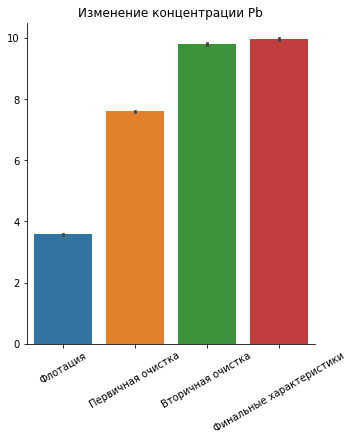

In [21]:
a = sns.catplot(data=df_pb, kind = 'bar')
a.set_xticklabels(["Флотация", "Первичная очистка", "Вторичная очистка", "Финальные характеристики"],
                 rotation = 30)
plt.title('Изменение концентрации Pb')
plt.show()

Концентрация свинца также увеличивается после каждого этапа, но в отличие от золота содеражения металла в 4 раза меньше

## 2.2. Сравнение распределение размеров гранул сырья на обучающей и тестовой выборках.

In [22]:
feed_size_train = df_train[['rougher.input.feed_size']].reset_index().drop(['date'], axis=1)
feed_size_train.columns = ['Обучающая выборка']
feed_size_test = df_test[['rougher.input.feed_size']].reset_index().drop(['date'], axis=1)
feed_size_test.columns = ['Тестовая выборка']
df_feed = pd.concat([feed_size_train, feed_size_test], axis=1).dropna()
df_feed.head()

,Обучающая выборка,Тестовая выборка
0,55.486599,62.710452
1,57.278666,61.961163
2,57.510649,66.903807
3,57.792734,59.865919
4,56.047189,63.315324


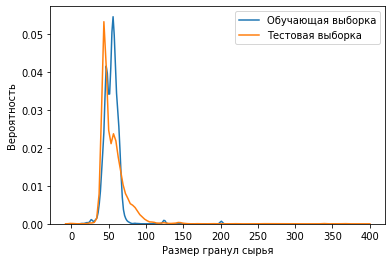

In [23]:
sns.kdeplot(df_feed['Обучающая выборка'])
sns.kdeplot(df_feed['Тестовая выборка'])
plt.ylabel('Вероятность')
plt.xlabel('Размер гранул сырья')
plt.show()

Исходя из графика видно, что распределение размеров гранул в обеих выборках примерно одинаковое.

## 2.3. Исследование суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. 

Заметили аномальные значения в суммарном распределении или нет? Если они есть, стоит ли их удалять из обеих выборок? Опишите выводы и удалите аномалии.

In [24]:
cols_1 = ['rougher.input.feed_au','rougher.input.feed_ag',
          'rougher.input.feed_pb','rougher.input.feed_sol']
df_1 = pd.DataFrame(df_full[cols_1].sum(axis=1)).reset_index().drop(['date'], axis=1)
df_1.columns = ['Флотация']

cols_2 = ['rougher.output.concentrate_au','rougher.output.concentrate_ag',
          'rougher.output.concentrate_pb','rougher.output.concentrate_sol']
df_2 = pd.DataFrame(df_full[cols_2].sum(axis=1)).reset_index().drop(['date'], axis=1)
df_2.columns = ['Первичная очистка']

cols_3 = ['primary_cleaner.output.concentrate_au','primary_cleaner.output.concentrate_ag',
          'primary_cleaner.output.concentrate_pb','primary_cleaner.output.concentrate_sol']
df_3 = pd.DataFrame(df_full[cols_3].sum(axis=1)).reset_index().drop(['date'], axis=1)
df_3.columns = ['Вторичная очистка']

cols_4 = ['final.output.concentrate_au', 'final.output.concentrate_ag',
          'final.output.concentrate_pb', 'final.output.concentrate_sol']
df_4 = pd.DataFrame(df_full[cols_4].sum(axis=1)).reset_index().drop(['date'], axis=1)
df_4.columns = ['Финальные характеристики']

df_c = df_1.join(df_2)
df_c = df_c.join(df_3)
df_c = df_c.join(df_4)

df_c.describe()

,Флотация,Первичная очистка,Вторичная очистка,Финальные характеристики
count,19439.000000,19439.000000,19439.000000,19439.000000
mean,57.320789,68.170865,60.764731,68.653624
std,7.212680,12.491279,10.017271,7.427536
min,0.040000,0.000000,0.000000,0.000000
25%,53.557679,66.012495,58.929364,67.932362
50%,57.594391,70.181495,62.497674,69.598444
75%,61.953459,74.356904,65.667336,71.368472
max,76.978947,88.140119,80.749343,80.210644


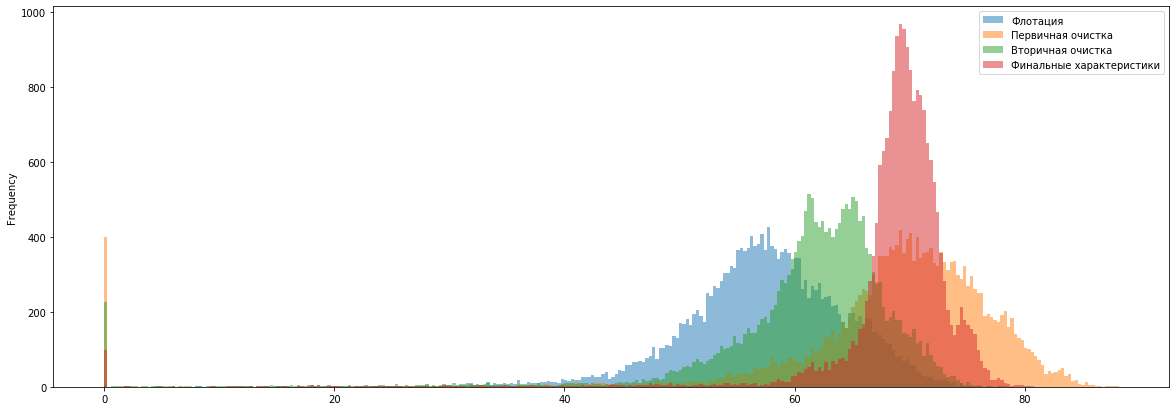

In [25]:
df_c.plot(kind='hist', alpha=0.5, bins=300, figsize=(20,7))
plt.show()

In [26]:
df_full = df_full.loc[(df_full['rougher.input.feed_au'] > 1) & (df_full['rougher.input.feed_ag'] > 1) & (df_full['rougher.input.feed_pb'] > 1)]
df_full = df_full.loc[(df_full['rougher.input.feed_sol'] > 1) & (df_full['rougher.output.concentrate_au'] > 1) & (df_full['rougher.output.concentrate_ag'] > 1)]
df_full = df_full.loc[(df_full['rougher.output.concentrate_pb'] > 1) & (df_full['rougher.output.concentrate_sol'] > 1)]
df_full = df_full.loc[(df_full['primary_cleaner.output.concentrate_au'] > 1) & (df_full['primary_cleaner.output.concentrate_ag'] > 1)]
df_full = df_full.loc[(df_full['primary_cleaner.output.concentrate_pb'] > 1) & (df_full['primary_cleaner.output.concentrate_sol'] > 1)]
df_full = df_full.loc[(df_full['final.output.concentrate_au'] > 1) & (df_full['final.output.concentrate_ag'] > 1)]
df_full = df_full.loc[(df_full['final.output.concentrate_pb'] > 1) & (df_full['final.output.concentrate_sol'] > 1)]


In [27]:
df_full.shape #before (18691, 86) after (18387, 86)
df_train.shape #before (14144, 54) after (13999, 54)

(14149, 54)

In [28]:
df_train = df_train.loc[(df_train['rougher.input.feed_au'] > 1) & (df_train['rougher.input.feed_ag'] > 1)]
df_train = df_train.loc[(df_train['rougher.input.feed_sol'] > 1) & (df_train['rougher.input.feed_pb'] > 1)]

df_test = df_test.loc[(df_test['rougher.input.feed_au'] > 1) & (df_test['rougher.input.feed_ag'] > 1)]
df_test = df_test.loc[(df_test['rougher.input.feed_sol'] > 1) & (df_test['rougher.input.feed_pb'] > 1)]

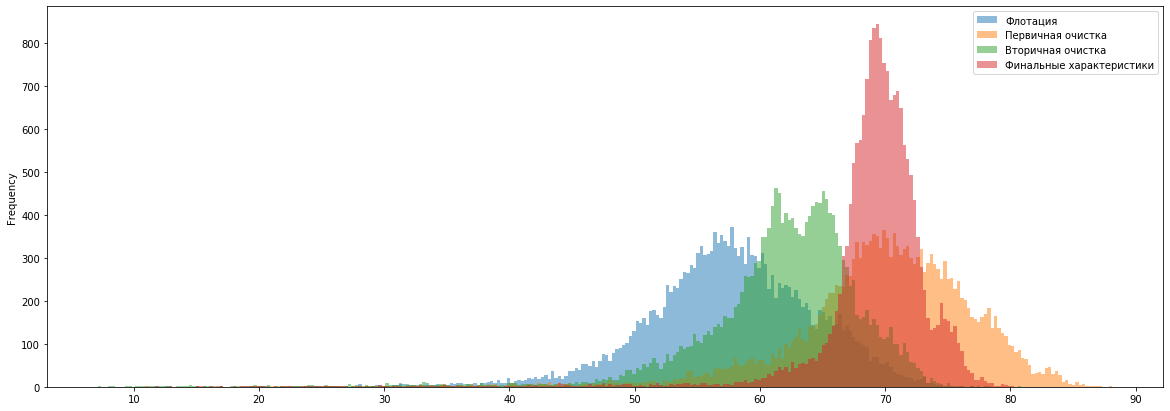

In [29]:
df_1 = pd.DataFrame(df_full[cols_1].sum(axis=1)).reset_index().drop(['date'], axis=1)
df_1.columns = ['Флотация']

df_2 = pd.DataFrame(df_full[cols_2].sum(axis=1)).reset_index().drop(['date'], axis=1)
df_2.columns = ['Первичная очистка']

df_3 = pd.DataFrame(df_full[cols_3].sum(axis=1)).reset_index().drop(['date'], axis=1)
df_3.columns = ['Вторичная очистка']

df_4 = pd.DataFrame(df_full[cols_4].sum(axis=1)).reset_index().drop(['date'], axis=1)
df_4.columns = ['Финальные характеристики']

df_x = df_1.join(df_2)
df_x = df_x.join(df_3)
df_x = df_x.join(df_4)

df_x.head()

df_x.plot(kind='hist', alpha=0.5, bins=300, figsize=(20,7))
plt.show()

Концентрации веществ больше всего на финальной стадии. Также нашли аномалию - суммарное количество 0 почти на всех стадиях, чего не может быть, их удалили.

# 3. Построение модели

## 3.1. Функция для вычисления итоговой sMAPE.

In [32]:
def sMAPE(y, y_pred):
    sMAPE = np.mean(((np.abs(y - y_pred)) / 
                  ((np.abs(y) + np.abs(y_pred)) / 2) * 100))
    return sMAPE

def sMAPE_grande(r, f):
    return (0.25 * r + 0.75 * f)

In [33]:
sMAPE_score = make_scorer(sMAPE, greater_is_better=False)

Готовы функции для вычисления метрики качества sMAPE

## 3.2. Подготовка данных для обучения

In [34]:
x_train = df_train.drop(['final.output.recovery','rougher.output.recovery'], axis=1)
y1_train = df_train['final.output.recovery']
y2_train = df_train['rougher.output.recovery']

x_test = df_test.drop(['final.output.recovery','rougher.output.recovery'], axis=1)
y1_test = df_test['final.output.recovery']
y2_test = df_test['rougher.output.recovery']

x_train.shape 
x_test.shape

(5276, 52)

Разбили выборки на обучающие признаки и 2 целевых признака, а также скомбинированную для финального теста

## 3.3. Модель линейной регрессии

In [35]:
#создание модели для первого целевого признака и расчет метрики качества
model_1 = LinearRegression()
sMAPE_r1 = cross_val_score(model_1, x_train, y1_train, scoring=sMAPE_score, cv=5).mean()
print('Средняя sMAPE модели для таргета 1:', sMAPE_r1 * (-1))

#создание модели для второго целевого признака и расчет метрики качества
sMAPE_f1 = cross_val_score(model_1, x_train, y2_train, scoring=sMAPE_score, cv=5).mean()
print('Средняя sMAPE модели для таргета 2:', sMAPE_f1 * (-1))

#вычисление итоговой метрики
sMAPE_1 = sMAPE_grande(sMAPE_r1, sMAPE_f1)
print('sMAPE финальный: {:.2f}'.format(sMAPE_1 * (-1)))

Средняя sMAPE модели для таргета 1: 11.971313778991922
Средняя sMAPE модели для таргета 2: 12.774081397480511
sMAPE финальный: 12.57


Построили классичесую модель линейной регрессии с итоговым sMAPE 12,57

## 3.4. Модель случайный лес

In [ ]:
rf = RandomForestRegressor(random_state = 42)

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(x_train, y1_train)
rf_random.best_params_

In [37]:
# лучший результат для таргета 1
model_2 = RandomForestRegressor(random_state=42, 
                                n_estimators=600, 
                                min_samples_split=10, 
                                min_samples_leaf=4, 
                                max_features='sqrt', 
                                max_depth=90, 
                                bootstrap=False)
model_2.fit(x_train, y1_train)
pred_2_1 = model_2.predict(x_test)
sMAPE_r2 = sMAPE(y1_test, pred_2_1)
print('sMAPE для целевого признака 1: {:.3f}'.format(sMAPE_r2))

sMAPE для целевого признака 1: 9.342


In [ ]:
rf = RandomForestRegressor(random_state = 42)

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(x_train, y2_train)
rf_random.best_params_

In [39]:
# лучший результат для таргета 2
model_3 = RandomForestRegressor(random_state=42,
                                 n_estimators=600, 
                                 min_samples_split=10, 
                                 min_samples_leaf=4, 
                                 max_features='sqrt', 
                                 max_depth=90, 
                                 bootstrap=False)

model_3.fit(x_train, y2_train)
pred_3 = model_3.predict(x_test)
sMAPE_f2 = sMAPE(y2_test, pred_3)
print('sMAPE для целевого признака 2: {:.3f}'.format(sMAPE_f2))

sMAPE для целевого признака 2: 10.226


In [40]:
# вычисление итоговой метрики
sMAPE_2 = sMAPE_grande(sMAPE_r2, sMAPE_f2)
print('sMAPE финальный: {:.2f}'.format(sMAPE_2))

sMAPE финальный: 10.00


Модель случайного леса sMAPE 10.005, что лучше результатов линейной регрессии

## 3.5. Тестирование модели

In [41]:
model_fin1 = RandomForestRegressor(random_state=42, 
                                n_estimators=600, 
                                min_samples_split=10, 
                                min_samples_leaf=4, 
                                max_features='sqrt', 
                                max_depth=90, 
                                bootstrap=False)
model_fin1.fit(x_train, y1_train)
predictions_final_1 = model_fin1.predict(x_test)
sMAPE_final_r1 = sMAPE(y1_test, predictions_final_1)
print('sMAPE для целевого признака 1: {:.3f}'.format(sMAPE_final_r1))

model_fin2 = RandomForestRegressor(random_state=42,
                                 n_estimators=600, 
                                 min_samples_split=10, 
                                 min_samples_leaf=4, 
                                 max_features='sqrt', 
                                 max_depth=90, 
                                 bootstrap=False)
model_fin2.fit(x_train, y2_train)
predictions_final_2 = model_fin2.predict(x_test)
sMAPE_final_f1 = sMAPE(y2_test, predictions_final_2)
print('sMAPE для целевого признака 2: {:.3f}'.format(sMAPE_final_f1))

print('sMAPE финальный: {:.3f}'.format(sMAPE_grande(sMAPE_final_r1, sMAPE_final_f1)))


sMAPE для целевого признака 1: 9.342
sMAPE для целевого признака 2: 10.226
sMAPE финальный: 10.005


## 3.6. Сравнение с константной моделью

In [45]:
from sklearn.dummy import DummyRegressor

dummy_clf = DummyRegressor(strategy="mean")
dummy_clf.fit(x_train, y1_train)
pred_dummy_1 = dummy_clf.predict(x_test)
sMAPE_dummy_1 = sMAPE(y1_test, pred_dummy_1)
print('sMAPE для целевого признака 1: {:.2f}'.format(sMAPE_dummy_1))

dummy_clf.fit(x_train, y2_train)
pred_dummy_2 = dummy_clf.predict(x_test)
sMAPE_dummy_2 = sMAPE(y2_test, pred_dummy_2)
print('sMAPE для целевого признака 2: {:.2f}'.format(sMAPE_dummy_2))

print('sMAPE финальный: {:.3f}'.format(sMAPE_grande(sMAPE_dummy_1, sMAPE_dummy_2)))

sMAPE для целевого признака 1: 10.09
sMAPE для целевого признака 2: 10.27
sMAPE финальный: 10.224


# 4. Выводы

Итого, была проделана следующая работа: 
1. Данные загружены и изучены: всего имеются 3 датасета (обучаемая, тестовая и полная выборки). Далее вручную посчитали и сравнили показатели эффективности обогащения: она не сильно отличается от предоставленной. После чего подготовили наборы для дальнейшей работы: из тренировочной убрали признаки, не входящие в тестовую и в последнюю добавили 2 таргета - final.output.recovery и rougher.output.recovery  
2. Проанализировали изменение концентрации металлов (Au, Ag, Pb) на различных этапах очистки — золота и серебра повышается, при этом свинца уменьшается после первичной очистки. Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках показали, что они сильно не отличаются. Исследовали суммарную концентрацию всех веществ на разных стадиях: на финальной, очевидно, она достигает пика.
3. Подготовили и создали свою функцию для вычисления итоговой sMAPE, разбили данные на признаки и таргеты. Обучили модель случайный лес с sMAPE 10, что лучше константной модели